# Parallelization with QInfer #

## Setup ##

We begin by enabling Python 3–style division, as is recommended for use in Python 2.7.

In [1]:
from __future__ import division

Next, we import the IPython parallelization library ``ipyparallel``, as well as QInfer itself and some useful things from the Python standard library.

In [2]:
import ipyparallel as ipp
import qinfer as qi
from functools import partial

/home/cgranade/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We'll make some nice graphical examples later, so we also import Matplotlib and point it to the ``ggplot`` stylesheet if available. We'll also tell Matplotlib to plot inline in our notebook.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot')
except:
    pass

Next, we setup the parallelization client. To start a cluster running, it's convienent to use the Jupyter Notebook extension. If you're running ``ipyparallel`` 5.0 or later, you can install the Notebook extension by running:
```
$ ipcluster nbextension enable
```
Full instructions for installing the Jupyter Notebook extension are available on the [``ipyparallel`` site](https://github.com/ipython/ipyparallel). In any case, once a cluster has been started, we can make a client that connects to it by using the ``Client()`` class.

In [4]:
client = ipp.Client()
print(client)

Once we get a client up and running, the next step is to make a *direct view* of its engines. Since we want to use all of the engines provided by the client, we index it by a slice ``[:]``.

In [5]:
dview = client[:]
print(dview)

<DirectView [0, 1, 2, 3,...]>


Next, we'll create a simple test model to try out parallelization support.

In [6]:
serial_model = qi.BinomialModel(qi.SimplePrecessionModel())
serial_model

Having made this model, we can then wrap it in ``DirectViewParallelizedModel`` to parallelize its likelihood function.

In [7]:
parallel_model = qi.DirectViewParallelizedModel(serial_model, dview)
parallel_model

Let's try it out by making a prior and specifying an experiment design heuristic.

In [8]:
prior = qi.UniformDistribution([0, 1])
heuristic_class = partial(qi.ExpSparseHeuristic, t_field='x', other_fields={'n_meas': 20})

The rest is handled by ``perf_test_multiple``, which will run our example many times and report on its performance. In this case, parallelizing an individual model is a bit silly, since the simple precession likelihood is fast enough that communication costs blow away the savings from parallelization. That said, it makes an illustrative example. In practice, running a parallel model makes the most sense if the model likelihood is slow to evaluate, and if you're interested in a small number of runs.

In [9]:
with qi.timing() as t:
    performance = qi.perf_test_multiple(
        100, parallel_model, 6000, prior, 200,
        heuristic_class, progressbar=qi.IPythonProgressBar
    )
print("Time elapsed: {:0.2f} s".format(t.delta_t))

/home/cgranade/anaconda/lib/python2.7/site-packages/qinfer/utils.py:109: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)
/home/cgranade/anaconda/lib/python2.7/site-packages/qinfer/resamplers.py:219: ResamplerWarning: Covariance has zero norm; adding in small covariance in resampler. Consider increasing n_particles to improve covariance estimates.
  ResamplerWarning


Time elapsed: 277.53 s


Let's plot the performance data to make sure that our test actually works.

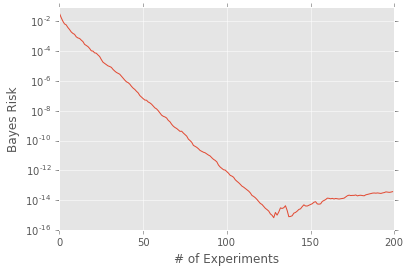

In [10]:
plt.semilogy(performance['loss'].mean(axis=0))
plt.xlabel('# of Experiments')
plt.ylabel('Bayes Risk')

Note that, in the above plot, we see both the exponential scaling we expect as well the errors caused by numerical precision once we get very close to the true model.

As an alternative to parallelizing over model parameters, we can parallelize over trials instead. That is, we send each trial to a different engine as they are able to handle new tasks. To do so, we'll use the ``LoadBalancedView`` offered by ``ipyparallel``. Parallelizing at the trial level instead is a much faster approach in this case, as it requires much less communication between the engines and the main process.

In [11]:
lbview = client.load_balanced_view()

In [12]:
with qi.timing() as t:
    performance = qi.perf_test_multiple(
        100, serial_model, 6000, prior, 200, heuristic_class,
        progressbar=qi.IPythonProgressBar, apply=lbview.apply
    )
print("Time elapsed: {:0.2f} s".format(t.delta_t))

Time elapsed: 13.70 s


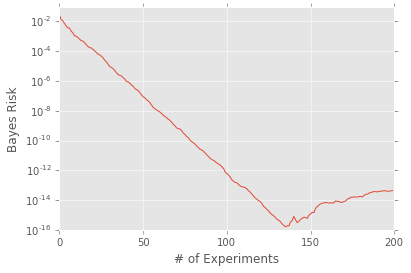

In [13]:
plt.semilogy(performance['loss'].mean(axis=0))
plt.xlabel('# of Experiments')
plt.ylabel('Bayes Risk')